<a href="https://colab.research.google.com/github/nehaa56789/Quantum-kmeans-clustering/blob/main/quantum_k_means.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install qiskit scikit-learn pandas numpy matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 70.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 98.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.2 MB/s eta 0:00:00


In [ ]:
pip install qiskit qiskit-aer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 56.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.metrics import silhouette_score, davies_bouldin_score
from qiskit import QuantumCircuit
from qiskit_aer import Aer

In [ ]:
from google.colab import files
uploaded = files.upload()

import io
df = pd.read_csv(io.BytesIO(uploaded['Crop_recommendation.csv']))

Saving Crop_recommendation.csv to Crop_recommendation.csv


In [ ]:
# Select soil features
features = ['N','P','K','temperature','humidity','ph','rainfall']
X = df[features].values

# --- Step 1: Preprocessing ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_norm = normalize(X_scaled, norm='l2')

In [ ]:
# --- Step 2: Amplitude Encoding into Quantum States ---
def amplitude_encode(x):
    """Return a normalized amplitude vector for a quantum state"""
    norm = np.linalg.norm(x)
    return x / norm if norm != 0 else x

def make_qc_from_vector(vec):
    """Make a quantum circuit with amplitude encoding"""
    n_qubits = int(np.ceil(np.log2(len(vec))))
    state = np.zeros(2**n_qubits)
    state[:len(vec)] = amplitude_encode(vec)
    norm = np.linalg.norm(state)
    state = state / norm
    qc = QuantumCircuit(n_qubits)
    qc.initialize(state, list(range(n_qubits)))
    return qc

In [ ]:
# --- Step 3: Quantum Similarity using SWAP test ---
def swap_test_similarity(vec1, vec2):
    # Prepare states
    qc1 = make_qc_from_vector(vec1)
    qc2 = make_qc_from_vector(vec2)

    n = qc1.num_qubits
    qc = QuantumCircuit(n*2+1, 1)

    # Load states on two registers
    qc.compose(qc1, qubits=range(1, n+1), inplace=True)
    qc.compose(qc2, qubits=range(n+1, 2*n+1), inplace=True)

    # SWAP test
    qc.h(0)
    for i in range(n):
        qc.cswap(0, i+1, i+1+n)
    qc.h(0)
    qc.measure(0, 0)

    backend = Aer.get_backend('qasm_simulator')
    job = backend.run(qc, shots=1024)
    result = job.result()
    counts = result.get_counts()

    prob0 = counts.get('0', 0) / 1024
    # Similarity = 2*prob0 - 1  (from SWAP test math)
    sim = max(0.0, 2*prob0 - 1)
    return sim


In [ ]:
# --- Step 4: Quantum K-Means ---
def quantum_kmeans(X, k=7, max_iters=5):
    np.random.seed(42)
    centroids = X[np.random.choice(len(X), k, replace=False)]

    for _ in range(max_iters):
        clusters = [[] for _ in range(k)]
        for x in X:
            sims = [swap_test_similarity(x, c) for c in centroids]
            # distance = sqrt(1 - similarity)
            dists = [np.sqrt(1 - s) for s in sims]
            label = np.argmin(dists)
            clusters[label].append(x)
        # update
        new_centroids = []
        for cluster in clusters:
            if cluster:
                new_centroids.append(np.mean(cluster, axis=0))
            else:
                new_centroids.append(X[np.random.randint(len(X))])
        centroids = np.array(new_centroids)
    labels = np.zeros(len(X), dtype=int)
    for i, x in enumerate(X):
        sims = [swap_test_similarity(x, c) for c in centroids]
        dists = [np.sqrt(1 - s) for s in sims]
        labels[i] = np.argmin(dists)
    return labels


In [ ]:
# --- Step 5: Run & Evaluate ---
labels = quantum_kmeans(X_norm, k=7)
print("Cluster labels:", labels[:30])  # Show first 30

print("Silhouette Score:", silhouette_score(X_norm, labels))
print("Davies-Bouldin Index:", davies_bouldin_score(X_norm, labels))

Cluster labels: [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 3 5 5 5 5 5 5 5 5]
Silhouette Score: 0.24297394396062455
Davies-Bouldin Index: 1.5945887869209456


In [ ]:
df['Quantum_Cluster'] = labels


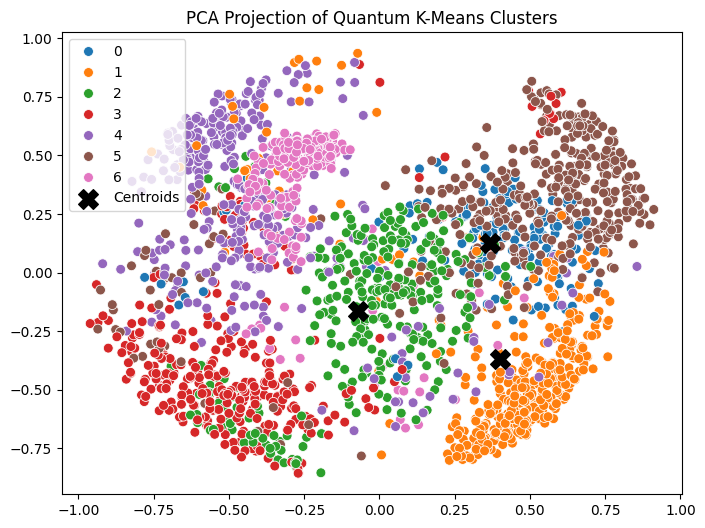

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_norm)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df['Quantum_Cluster'], palette='tab10', s=50)
# Optional: overlay centroids
quantum_centroids = np.array([X_norm[df['Quantum_Cluster']==i].mean(axis=0) for i in range(3)])
centers_pca = pca.transform(quantum_centroids)
plt.scatter(centers_pca[:,0], centers_pca[:,1], c='black', s=200, marker='X', label='Centroids')
plt.title("PCA Projection of Quantum K-Means Clusters")
plt.legend()
plt.show()


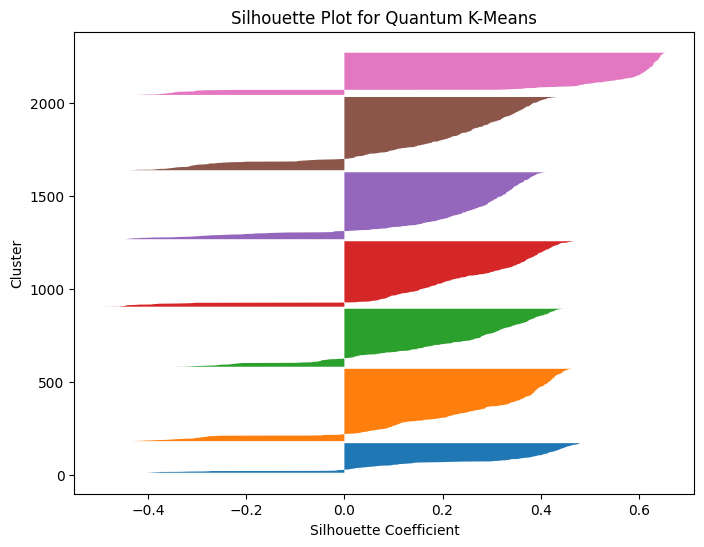

In [ ]:
from sklearn.metrics import silhouette_samples
import numpy as np

sil_samples = silhouette_samples(X_norm, df['Quantum_Cluster'])
y_lower = 10
plt.figure(figsize=(8,6))

k = 7  # number of quantum clusters
for i in range(k):
    ith_cluster_silhouette = sil_samples[df['Quantum_Cluster'] == i]
    ith_cluster_silhouette.sort()
    plt.fill_betweenx(np.arange(y_lower, y_lower + len(ith_cluster_silhouette)),
                      0, ith_cluster_silhouette)
    y_lower += len(ith_cluster_silhouette) + 10

plt.xlabel("Silhouette Coefficient")
plt.ylabel("Cluster")
plt.title("Silhouette Plot for Quantum K-Means")
plt.show()


Davies-Bouldin Index (Quantum): 1.5946
Calinski-Harabasz Index (Quantum): 301.9364


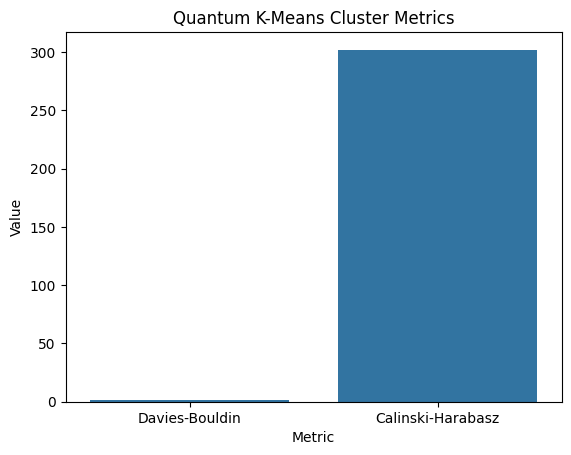

In [ ]:
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score

dbi = davies_bouldin_score(X_norm, df['Quantum_Cluster'])
chi = calinski_harabasz_score(X_norm, df['Quantum_Cluster'])
print(f"Davies-Bouldin Index (Quantum): {dbi:.4f}")
print(f"Calinski-Harabasz Index (Quantum): {chi:.4f}")

# Bar chart
import pandas as pd
metrics_df = pd.DataFrame({'Metric': ['Davies-Bouldin', 'Calinski-Harabasz'],
                           'Value': [dbi, chi]})
sns.barplot(x='Metric', y='Value', data=metrics_df)
plt.title('Quantum K-Means Cluster Metrics')
plt.show()


/tmp/ipython-input-559291245.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='tab10')


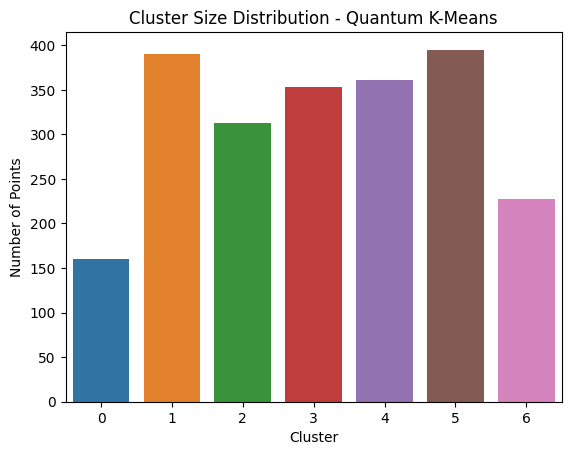

In [ ]:
cluster_counts = df['Quantum_Cluster'].value_counts().sort_index()
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='tab10')
plt.xlabel('Cluster')
plt.ylabel('Number of Points')
plt.title('Cluster Size Distribution - Quantum K-Means')
plt.show()
